# <a href="https://mipt-stats.gitlab.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 9. Байесовские классификаторы.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds22_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image`;
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.



**Баллы за задание:**

* Задача 1 &mdash; 30 баллов
* Задача 2 &mdash; 28 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.2, palette='Set2')
%matplotlib inline

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [2]:
from sklearn.datasets import fetch_20newsgroups
import warnings
warnings.simplefilter("ignore")

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from collections import Counter


Перед выполнением задания обязательно посмотрите <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/estimators.html">ноутбук</a> с занятия по оценкам параметров.

---
### Задача 1.

На занятии мы уже научились классифицировать текстовые сообщения на нормальные и спам. Теперь перед вами стоит более серьезная задача &mdash; построить систему, автоматически классифицирующую поступающие новостные сюжеты на несколько заранее заданных категорий.
 
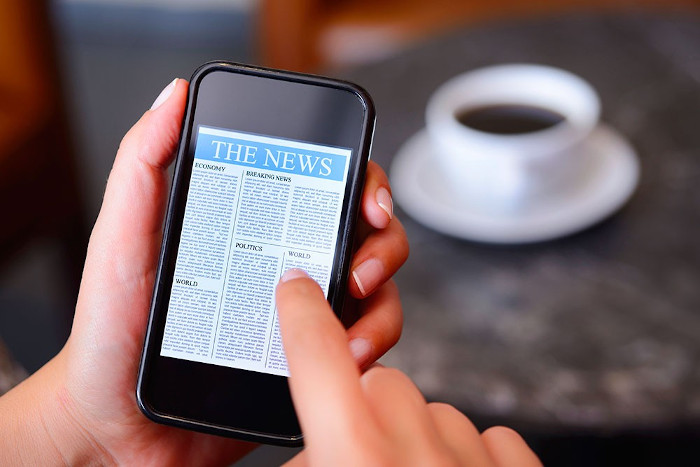



Перед выполнением задачи обязательно посмотрите <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/bayes_classification.html">ноутбук</a> с занятия по классификации.

---

С помощью кода ниже загрузите встроенные в `sklearn` <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups">данные</a>, в которых представлены различные новостные сюжеты, разделенные на 20 тематических групп.

In [3]:
# удаляем заголовки и подписи
remove = ('headers', 'footers')
# зафиксируем зерно случайности
random_state = 42

# Извлекаем обучающую и тестовую части перемешивая случайным образом
data_train = fetch_20newsgroups(
    subset='train', shuffle=True, random_state=random_state, remove=remove
)
data_test = fetch_20newsgroups(
    subset='test', shuffle=True, random_state=random_state, remove=remove
)

Посмотрим на какое-нибудь сообщение

In [4]:
print(data_train['data'][21])

In article <1993Apr20.151818.4319@samba.oit.unc.edu> Scott.Marks@launchpad.unc.edu (Scott Marks) writes:
>>And of course, Mike Ramsey was (at one time) the captain in Buffalo prior to
>>being traded to Pittsburgh.  Currently, the Penguins have 3 former captains
>>and 1 real captain (Lemieux) playing for them.  They rotate the A's during the
>>season (and even the C while Mario was out).  Even Troy Loney has worn the C
>>for the Pens.
>

I think that Mike Foligno was the captain of the Sabres when he
got traded to the Leafs. Also, wasn't Rick Vaive the captain of
the Leafs when he got traded to Chicago (with Steve Thomas for
Ed Olcyzk and someone). Speaking of the Leafs, I believe that
Darryl Sittler was their captain (he'd torn the "C" off his
jersey but I think he re-claimed the captaincy later on) when he
was traded to the Flyers.

Oh yeah, of course, Gretzky was the captain of the Oilers before
he was traded wasn't he? 


Индекс тематической группы для каждого сообщения

In [5]:
data_train['target']

array([7, 4, 4, ..., 3, 1, 8])

Названия тематических групп

In [6]:
data_train['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

С помощью методов, изученных в рамках нашего курса, постройте классификатор новостных сюжетов на тематические группы. При построении классификатора **запрещено пользоваться тестовой выборкой**. Для настройки классификатора, например, выбора оптимальных гиперпараметров, можно разделить обучающую выборку на две части &mdash; непосредственно обучающую и валидационную. Первую часть использовать для непосредственного обучения, а вторую &mdash; для настройки, пытаясь по ней оптимизировать качество.

In [7]:
for i in data_train.keys():
    print(len(data_train[i]))

11314
11314
20
11314
10617


In [8]:
data_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [9]:
data_train['filenames']

array(['/Users/ila/scikit_learn_data/20news_home/20news-bydate-train/rec.autos/102994',
       '/Users/ila/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.mac.hardware/51861',
       '/Users/ila/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.mac.hardware/51879',
       ...,
       '/Users/ila/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.ibm.pc.hardware/60695',
       '/Users/ila/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38319',
       '/Users/ila/scikit_learn_data/20news_home/20news-bydate-train/rec.motorcycles/104440'],
      dtype='<U91')

In [10]:
new_dict = {}
new_dict['data'] = data_train['data']
new_dict['target'] = data_train['target']

In [11]:
train = pd.DataFrame.from_dict(new_dict)

In [12]:
new_dict = {}
new_dict['data'] = data_test['data']
new_dict['target'] = data_test['target']
test = pd.DataFrame.from_dict(new_dict)

In [13]:
train, validation = train_test_split(train, test_size=0.25, random_state=42)

In [14]:
counts = pd.value_counts(train['target'], sort=True)
counts

10    464
5     457
9     456
2     449
15    449
13    449
6     448
12    447
1     446
3     445
8     443
14    441
11    439
7     430
17    429
4     421
16    396
0     363
18    328
19    285
Name: target, dtype: int64

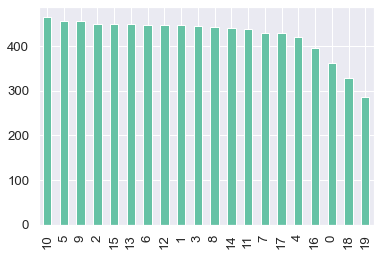

In [15]:
counts.plot(kind='bar');

Видим, что распределение по темам в выборке практически одинаковое, только статей на 19 тему сильно меньше

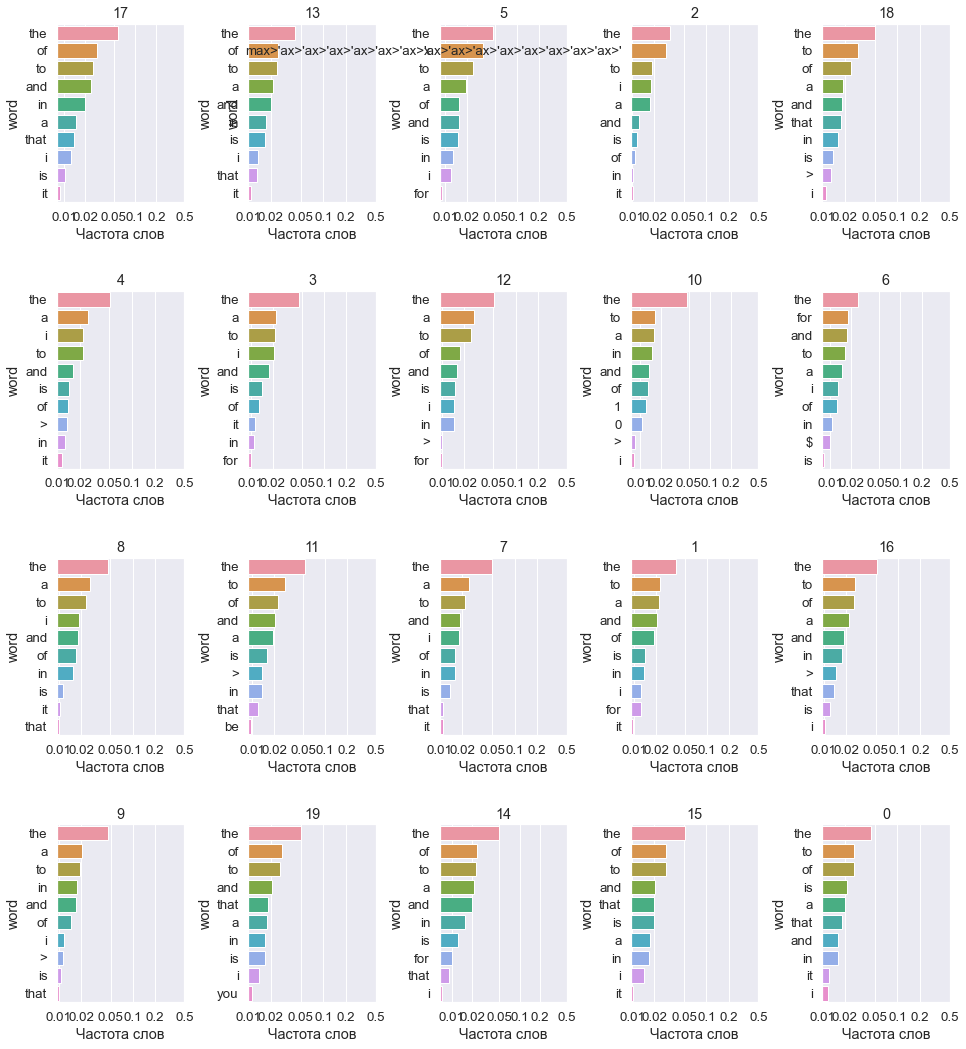

In [16]:
# метки сетки по оси икс
labels = [1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1]

plt.figure(figsize=(16, 18))

for i, label in enumerate(train['target'].unique()):
    all_words = ' '.join(
        train[train['target'] == label]['data']
    ).lower().replace('.', '').split()
    words_count = len(all_words)

    counts = Counter(all_words).most_common(10)
    counts = pd.DataFrame(counts, columns=['word', 'count'])
    
    plt.subplot(4, 5, i+1);
    sns.barplot(y=counts['word'], x=counts['count']/words_count);
    plt.xscale('log');
    plt.xlabel('Частота слов');
    plt.xticks(labels, labels);
    plt.title(label)
    
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.tight_layout();

Видим, что во всех классах the самое часто встречающееся, а также слова of, to, a

In [17]:
#vectorizer = CountVectorizer(min_df=0.01, max_df=0.05)
vectorizer = CountVectorizer()

vec_data_train = vectorizer.fit_transform(train['data']).toarray()
vec_data_test = vectorizer.transform(test['data']).toarray()


In [18]:
print(len(vectorizer.get_feature_names()))
print(vectorizer.get_feature_names())

102892
['00', '000', '0000', '00000', '000000', '00000000', '0000000004', '00000000b', '00000001', '00000001b', '00000010', '00000010b', '00000011', '00000011b', '00000074', '00000093', '000000e5', '00000100', '00000100b', '00000101', '00000101b', '00000110', '00000110b', '00000111', '00000111b', '000005102000', '00000510200001', '00000ee5', '00001000', '00001000b', '00001001', '00001001b', '00001010', '00001010b', '00001011', '00001011b', '000010af', '00001100', '00001100b', '00001101', '00001101b', '00001110', '00001110b', '00001111', '00001111b', '000021', '000042', '000062david42', '000094', '0000vec', '0001', '00010000', '00010000b', '00010001', '00010001b', '00010010', '00010010b', '00010011', '00010011b', '00010100', '00010100b', '00010101', '00010101b', '00010110', '00010110b', '00010111', '00010111b', '00011000', '00011000b', '00011001', '00011001b', '00011010', '00011010b', '00011011', '00011011b', '00011100', '00011100b', '00011101', '00011101b', '00011110', '00011110b', '00

In [19]:
#multinomial_nb = MultinomialNB()
#multinomial_nb.fit(vec_data_train, train['target'])

0.001
0.011
0.020999999999999998
0.030999999999999996
0.040999999999999995
0.05099999999999999
0.06099999999999999
0.071
0.08099999999999999
0.09099999999999998


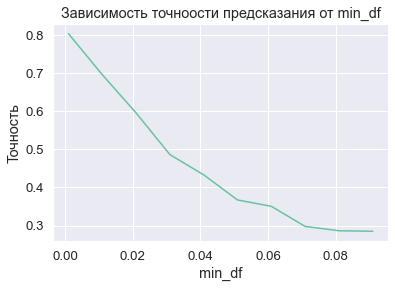

In [22]:
x_arr = np.arange(1e-3, 1e-1, 1e-2)
y_arr = []
multinomial_nb = MultinomialNB()
for min_df in np.arange(1e-3, 1e-1, 1e-2):
    vectorizer = CountVectorizer(min_df=min_df, max_df=5 * (1e-1))
    vec_data_train = vectorizer.fit_transform(train['data']).toarray()
    vec_data_val = vectorizer.transform(validation['data']).toarray()
    multinomial_nb.fit(vec_data_train, train['target'])
    predictions = multinomial_nb.predict(vec_data_val)
    corr_arr = validation['target']
    #print(f'Точность: {accuracy_score(corr_arr, predictions) :.3}')
    y_arr.append(accuracy_score(corr_arr, predictions))
    print(min_df)
plt.title('Зависимость точноости предсказания от min_df')
plt.xlabel('min_df')
plt.ylabel('Точность')
plt.plot(x_arr, y_arr)
plt.show()

Можно сделать вывод, что оптимальное min_df это 0, однако, подсчет модели занимает очень много времени, оставим 0.001

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49


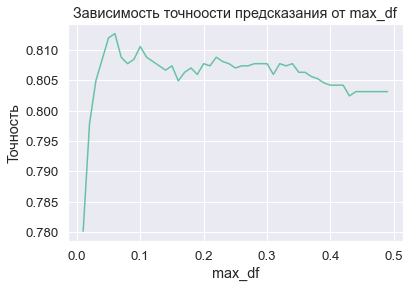

In [23]:
x_arr = np.arange(1e-2, 5 * 1e-1, 1e-2)
y_arr = []
multinomial_nb = MultinomialNB()
for max_df in np.arange(1e-2, 5 * 1e-1, 1e-2):
    vectorizer = CountVectorizer(min_df=1e-3, max_df=max_df)
    vec_data_train = vectorizer.fit_transform(train['data']).toarray()
    vec_data_val = vectorizer.transform(validation['data']).toarray()
    multinomial_nb.fit(vec_data_train, train['target'])
    predictions = multinomial_nb.predict(vec_data_val)
    corr_arr = validation['target']
    #print(f'Точность: {accuracy_score(corr_arr, predictions) :.3}')
    y_arr.append(accuracy_score(corr_arr, predictions))
    print(max_df)
plt.plot(x_arr, y_arr)
plt.title('Зависимость точноости предсказания от max_df')
plt.xlabel('max_df')
plt.ylabel('Точность')
plt.show()

Можно сделать вывод, что оптимальное max_df это 0.05-0.06

In [26]:
vectorizer = CountVectorizer(min_df=1e-3, max_df=0.06)
vec_data_train = vectorizer.fit_transform(train['data']).toarray()
vec_data_val = vectorizer.transform(validation['data']).toarray()

Теперь подберем гиперпарметр alpha

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


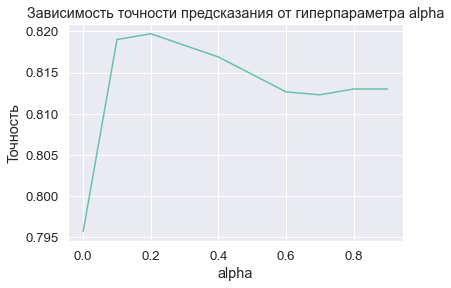

In [27]:
x_arr = np.arange(0, 1, 1e-1)
y_arr = []
for alpha in np.arange(0, 1, 1e-1):
    multinomial_nb = MultinomialNB(alpha=alpha)
    multinomial_nb.fit(vec_data_train, train['target'])
    predictions = multinomial_nb.predict(vec_data_val)
    corr_arr = validation['target']
    #print(f'Точность: {accuracy_score(corr_arr, predictions) :.3}')
    y_arr.append(accuracy_score(corr_arr, predictions))
    print(alpha)
plt.plot(x_arr, y_arr)
plt.title('Зависимость точности предсказания от гиперпараметра alpha')
plt.xlabel('alpha')
plt.ylabel('Точность')
plt.show()

Посмотрим теперь, что будет происходить при alpha > 1 

1
2
3
4
5
6
7
8
9
10


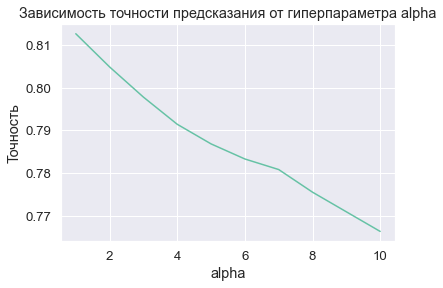

In [28]:
x_arr = np.arange(1, 11, 1)
y_arr = []
for alpha in np.arange(1, 11, 1):
    multinomial_nb = MultinomialNB(alpha=alpha)
    multinomial_nb.fit(vec_data_train, train['target'])
    predictions = multinomial_nb.predict(vec_data_val)
    corr_arr = validation['target']
    #print(f'Точность: {accuracy_score(corr_arr, predictions) :.3}')
    y_arr.append(accuracy_score(corr_arr, predictions))
    print(alpha)
plt.plot(x_arr, y_arr)
plt.title('Зависимость точности предсказания от гиперпараметра alpha')
plt.xlabel('alpha')
plt.ylabel('Точность')
plt.show()

Я перебрал всего около 20 параметров alpha, это заняло достаточно большое время, на мой взгляд, оптимальное значение alpha это 0.2

Посчитайте качество на тестовой выборке.

In [30]:
vectorizer = CountVectorizer(min_df=1e-3, max_df=0.06)
vec_data_train = vectorizer.fit_transform(train['data']).toarray()
vec_data_test = vectorizer.transform(test['data']).toarray()
multinomial_nb = MultinomialNB(alpha=0.2)
multinomial_nb.fit(vec_data_train, train['target'])
predictions = multinomial_nb.predict(vec_data_test)
corr_arr = test['target']
print(f'Точность: {accuracy_score(corr_arr, predictions) :.3}')

Точность: 0.736


Посмотрим, действительно ли это много на массиве из одного типа

In [33]:
for i in range(20):
    predictions = [i] * len(predictions)
    print(f'Точность: {accuracy_score(corr_arr, predictions) :.3}')

Точность: 0.0424
Точность: 0.0516
Точность: 0.0523
Точность: 0.052
Точность: 0.0511
Точность: 0.0524
Точность: 0.0518
Точность: 0.0526
Точность: 0.0528
Точность: 0.0527
Точность: 0.053
Точность: 0.0526
Точность: 0.0522
Точность: 0.0526
Точность: 0.0523
Точность: 0.0528
Точность: 0.0483
Точность: 0.0499
Точность: 0.0412
Точность: 0.0333


На случайном массиве

In [34]:
for i in range(20):
    predictions = np.random.randint(0, 20, size = len(predictions)) 
    print(f'Точность: {accuracy_score(corr_arr, predictions) :.3}')

Точность: 0.0497
Точность: 0.052
Точность: 0.051
Точность: 0.0515
Точность: 0.0495
Точность: 0.0502
Точность: 0.0499
Точность: 0.0526
Точность: 0.051
Точность: 0.047
Точность: 0.0466
Точность: 0.0542
Точность: 0.0477
Точность: 0.0482
Точность: 0.0477
Точность: 0.0482
Точность: 0.0556
Точность: 0.0527
Точность: 0.0483
Точность: 0.052


Посмотрим на точность без подбора гиперпараметров

In [35]:
vectorizer = CountVectorizer()
vec_data_train = vectorizer.fit_transform(train['data']).toarray()
vec_data_test = vectorizer.transform(test['data']).toarray()
multinomial_nb = MultinomialNB()
multinomial_nb.fit(vec_data_train, train['target'])
predictions = multinomial_nb.predict(vec_data_test)
corr_arr = test['target']
print(f'Точность: {accuracy_score(corr_arr, predictions) :.3}')

Точность: 0.663


Сделайте выводы.

Подобрав гиперпараметры для vectorizer и для классификатора смогли улучшить результат модели на 6%. Данная модель значительно превосходит тривиаальные модели с одинаковым типом и модели с рандомными ответами, можно сказать, что достаигли хорошей точности с помощью классификатора<br>
Поскольку все типы присутствуют примерно в одинаковых масштабах, то модели, возвращающие один и тот же тип статей на любую темы сильно проигрывают

---
### Задача 2.
Пусть $\mathscr{X} = \mathbb{R}^2$ — пространство признаков, $\mathscr{Y} = \{0, 1\}$ — множество классов. Рассматривается квадратичный дискриминантный анализ. Условное распределение $X$ при условии $Y=k$ равно $\mathcal{N}(a_k, \Sigma_k)$. Приведите примеры таких параметров $a_k, \Sigma_k$ и вероятностей $\mathsf{P}(Y = k)$, при которых разделяющая поверхность является
* гиперболой;
* параболой;
* двумя параллельными прямыми;
* двумя пересекающимися прямыми.